This is used to process data into .pkl files

In [1]:


import numpy as np
import json
import imageio 


def generate_mask(bd_pts=None, img_rows=None, lesion=None):
    """ Generate masks from boundary surfaces and lesion masks

        Args:
            bd_pts: boundary surfaces, shape = [bds, img_cols]
            lesion: lesion masks, shape =  [img_rows, img_cols] 

        Returns:
            label: training labels, shape = (img_rows, img_cols)

    """
    bds,img_cols = bd_pts.shape
    if img_rows is None:
        assert lesion is not None
        img_rows = lesion.shape[0]
    label = np.zeros((img_rows,img_cols))*np.nan
    for j in range(img_cols):
        
        cols = np.arange(img_rows)
        index = cols - bd_pts[0,j] < 0
        label[index,j] = 0
        index = cols - bd_pts[bds-1,j] >= 0
        label[index,j] = bds
        for k in range(bds-1):
            index_up = cols - bd_pts[k,j] >= 0
            index_down = cols - bd_pts[k+1,j] < 0
            label[index_up&index_down,j] = k+1
    if lesion is not None:
        label[lesion>0] = bds+1

    return label


In [2]:

import os

labels_pt = "data/cirrus/label"
images_pt = "data/cirrus/image"
# labels_pt = "data/spectralis/hcval/label"
# images_pt = "data/spectralis/hcval/image"

## read image
labels_files = os.listdir(labels_pt)
labels_files = sorted(labels_files)
images_files = os.listdir(images_pt)
images_files = sorted(images_files)

file_names = [x.split('.')[0] for x in labels_files] ## list

print(len(labels_files),len(images_files))

images_data_list = []
labels_data_list = []
for image_file,label_file in zip(images_files,labels_files):
    image_pt = os.path.join(images_pt,image_file)
    label_pt = os.path.join(labels_pt,label_file)

    image = np.array(imageio.imread(str(image_pt),pilmode = 'L'))/255
    images_data_list.append(image)
    with open(str(label_pt),'r') as f:
        dicts = json.loads(f.read())

    if 'lesion' in dicts.keys():
        mask = np.array(dicts['lesion'])
        mask[mask>1] = 1
    else:    
        mask = np.zeros(image.shape)

    bds = np.array(dicts['bds'], dtype=float) - 1 
    label = generate_mask(bd_pts=bds,lesion=mask)
    labels_data_list.append(label)

    image_file_name = image_file.split('.')[0]
    label_file_name = label_file.split('.')[0]

    if image_file_name != label_file_name:
        print("image_file_name != label_file_name")
        print(image_file)
        print(label_file)
        break
    assert image.shape == label.shape


48 48


/tmp/ipykernel_3821066/1016019205.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = np.array(imageio.imread(str(image_pt),pilmode = 'L'))/255


In [3]:
import pickle

print(len(images_data_list))
print(len(labels_data_list))
print(len(file_names))
images_data_list = np.array(images_data_list)
labels_data_list = np.array(labels_data_list)

data = {'images':images_data_list,'labels':labels_data_list, 'file_names':file_names}

## save data
f_name = 'data/cirrus/data.pkl'
with open(f_name, 'wb') as f:
    pickle.dump(data, f)

48
48
48


In [4]:
## load data
with open(f_name, 'rb') as f:
    data = pickle.load(f)

new_labels = data['labels']
new_images = data['images']
new_filenames = data['file_names']

print(np.max(new_images[0]))
print(np.max(new_labels[0]))

1.0
9.0


### Part II
开始载入数据

In [1]:
import pickle

f_val = "data/spectralis/hcval/data.pkl"
f_train = "data/spectralis/hctrain/data.pkl"
f_test = "data/spectralis/hceval/data.pkl"

with open(f_val, 'rb') as f:
    data_val = pickle.load(f)

labels_val = data_val['labels']
images_val = data_val['images']
filenames_val = data_val['file_names']


with open(f_train, 'rb') as f:
    data_train = pickle.load(f)

labels_train = data_train['labels']
images_train = data_train['images']
filenames_train = data_train['file_names']

with open(f_test, 'rb') as f:
    data_test = pickle.load(f)

labels_test = data_test['labels']
images_test = data_test['images']
filenames_test = data_test['file_names']


In [2]:
import numpy as np
import torch

## 调整数据size
images_train = images_train[:, np.newaxis, :, :]
images_val = images_val[:, np.newaxis, :, :]
labels_train = labels_train[:, np.newaxis, :, :]
labels_val = labels_val[:, np.newaxis, :, :]
images_test = images_test[:, np.newaxis, :, :]
labels_test = labels_test[:, np.newaxis, :, :]

## 转化为torch tensor
labels_train = torch.tensor(labels_train, dtype=torch.float32)
labels_val = torch.tensor(labels_val, dtype=torch.float32)
images_train = torch.tensor(images_train, dtype=torch.float32)
images_val = torch.tensor(images_val, dtype=torch.float32)
labels_test = torch.tensor(labels_test, dtype=torch.float32)
images_test = torch.tensor(images_test, dtype=torch.float32)


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# 设置超参数
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## label转化为one-hot
print(labels_train.shape)

def to_one_hot(labels_train):
    num, _, h, w = labels_train.size()
    labels_train_flat = labels_train.view(-1).long()
    one_hot_labels = F.one_hot(labels_train_flat, num_classes=NUM_CLASSES)
    one_hot_labels = one_hot_labels.view(num, NUM_CLASSES, h, w)
    return one_hot_labels.float()

labels_train = to_one_hot(labels_train)
labels_val = to_one_hot(labels_val)
labels_test = to_one_hot(labels_test)

print(labels_train.shape)
print(labels_val[0,:,0,0])

## 创建dataset和加载器
train_dataset = TensorDataset(images_train, labels_train)
val_dataset = TensorDataset(images_val, labels_val)
test_dataset = TensorDataset(images_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(len(train_loader), len(val_loader))


torch.Size([588, 1, 128, 1024])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [9., 9., 9.,  ..., 9., 9., 9.],
         [9., 9., 9.,  ..., 9., 9., 9.],
         [9., 9., 9.,  ..., 9., 9., 9.]]])
74 19


In [4]:
from ResUnet import *

def train_one_epoch(model, optimizer, criterion, data_loader, device):
    model.train()
    train_loss = 0.0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        print(outputs.shape, labels.shape)
        # outputs = 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    return train_loss / len(data_loader)

def validate(model, criterion, data_loader, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
    return val_loss / len(data_loader)

output_dir = "output"

model = ResUnet(1, 10).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_val_loss = float('inf')
losses_train = []
bst_model_num = 0
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader, DEVICE)
    losses_train.append(train_loss)

    if epoch % 5 == 0:
        val_loss = validate(model, criterion, val_loader, DEVICE)
        torch.save(model.state_dict(), output_dir+ '/checkpoints/model_at_epoch_{:02d}.pth'.format(epoch+1))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            bst_model_num = epoch+1
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
print("Best model at epoch: ", bst_model_num)


torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Size([8, 10, 128, 1024]) torch.Size([8, 10, 128, 1024])
torch.Si

KeyboardInterrupt: 

(128, 1024)


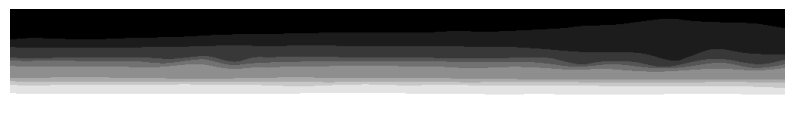

In [ ]:
import matplotlib.pyplot as plt

print(images_data[0].shape)
plt.figure(figsize=(10, 10))
plt.imshow(labels_data[0], cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.show()